In [23]:
import numpy as np

from PIL import Image, ImageFilter
from matplotlib import pylab as pylab
from matplotlib import pyplot as plt

from scipy.fft import dct, idct
from scipy.signal.windows import kaiser_bessel_derived as kbdw
import scipy.signal.windows as windows

# %matplotlib inline
pylab.rcParams['figure.figsize'] = (8, 8)

from pathlib import Path

image = 'wood'
size  = 2048

experiment = '2lap'

output = Path('outputs') / f'{image}-{size}'

output.mkdir(exist_ok=True, parents=True)

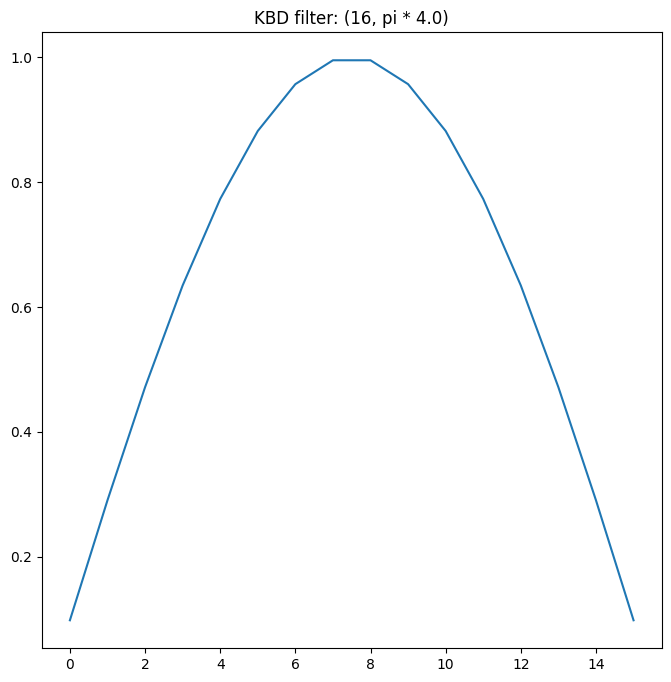

In [24]:
N=16

dct_type = 4
dct_norm = 'ortho'
kbd_alpha = 4.0
# kbd_alpha = 3.4

wfltr = kbdw(N, np.pi * kbd_alpha) # upto 709

wfltr = windows.cosine(16)

plt.figure()
plt.plot(wfltr)
plt.title(f"KBD filter: (16, pi * {kbd_alpha})")

plt.savefig(f'{output}/kbd.png')

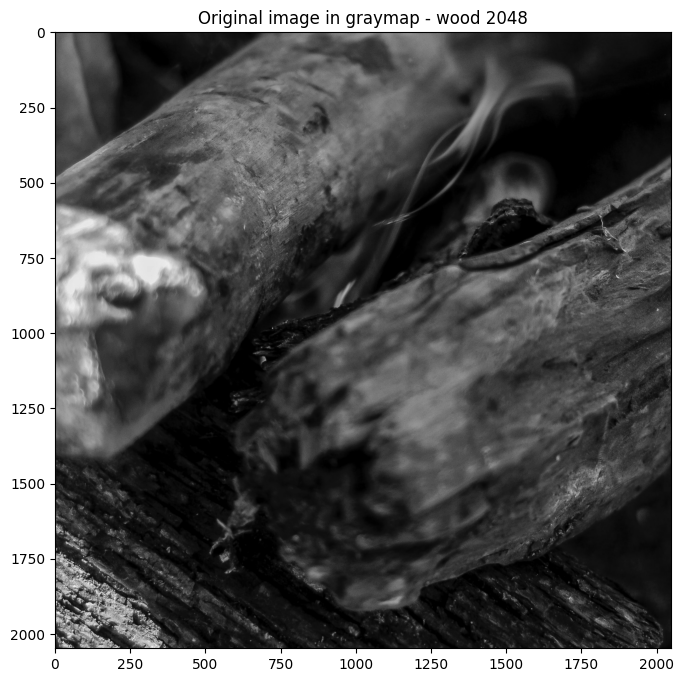

In [25]:
y, cb, cr = Image.open(f'../../images/{image}/{image}-{size}.png').convert('YCbCr').split()
# y, cb, cr = Image.open(f'../../images/{image}-{size}.png').convert('YCbCr').split()

im = np.array(y)
im = im[:im.shape[0] - im.shape[0]%8, :im.shape[1] - im.shape[1]%8]

im = im.astype(np.int64)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title(f"Original image in graymap - {image} {size}")

plt.imsave(f'{output}/original.png', im, cmap='gray')

In [26]:
def mdct(x):
    N = x.shape[0]

    if N%4 != 0:
        raise ValueError("MDCT4 only defined for vectors of length multiple of four.")

    N4 = N // 4

    a = x[0*N4:1*N4]
    b = x[1*N4:2*N4]
    c = x[2*N4:3*N4]
    d = x[3*N4:4*N4]

    br = np.flip(b)
    cr = np.flip(c)

    return dct(np.hstack([-cr - d, a - br]), type=4, norm='ortho', orthogonalize=True) / 2


def imdct(y):
    N = y.shape[0] * 2

    if N%4 != 0:
        raise ValueError("IMDCT is only defined for vectors lengths multiple of two.")
    
    N4 = N // 4

    z = idct(y, type=4, norm='ortho', orthogonalize=True)

    z = np.hstack([z, -np.flip(z), -z]) * 2

    return z[N4:5*N//4]


def mdct4(x):
    N = x.shape[0]
    if N%4 != 0:
        raise ValueError("MDCT4 only defined for vectors of length multiple of four.")
    M = N // 2
    N4 = N // 4
    
    rot = np.roll(x, N4)
    rot[:N4] = -rot[:N4]
    t = np.arange(0, N4)
    w = np.exp(-1j*2*np.pi*(t + 1./8.) / N)
    c = np.take(rot,2*t) - np.take(rot, N-2*t-1) \
        - 1j * (np.take(rot, M+2*t) - np.take(rot,M-2*t-1))
    c = (2./np.sqrt(N)) * w * np.fft.fft(0.5 * c * w, N4)
    y = np.zeros(M)
    y[2*t] = np.real(c[t])
    y[M-2*t-1] = -np.imag(c[t])
    return y

def imdct4(x):
    N = x.shape[0]
    if N%2 != 0:
        raise ValueError("iMDCT4 only defined for even-length vectors.")
    M = N // 2
    N2 = N*2
    
    t = np.arange(0,M)
    w = np.exp(-1j*2*np.pi*(t + 1./8.) / N2)
    c = np.take(x,2*t) + 1j * np.take(x,N-2*t-1)
    c = 0.5 * w * c
    c = np.fft.fft(c,M)
    c = ((8 / np.sqrt(N2))*w)*c
    
    rot = np.zeros(N2)
    
    rot[2*t] = np.real(c[t])
    rot[N+2*t] = np.imag(c[t])
    
    t = np.arange(1,N2,2)
    rot[t] = -rot[N2-t-1]
    
    t = np.arange(0,3*M)
    y = np.zeros(N2)
    y[t] = rot[t+M]
    t = np.arange(3*M,N2)
    y[t] = -rot[t-3*M]
    return y

In [27]:


im_hpad = np.copy(im)

im_hpad = np.hstack([
    im_hpad[:, 8:0:-1],
    im_hpad,
    im_hpad[:, -1:-9:-1]
])

im_mdct = np.ones([im.shape[0], im.shape[1]+8])

for i in range(im_hpad.shape[0]):
    for j in range(0, im_hpad.shape[1] - 8, 8):
        im_mdct[i][j:j+8] = mdct(im_hpad[i][j:j+16] * wfltr)
        
        

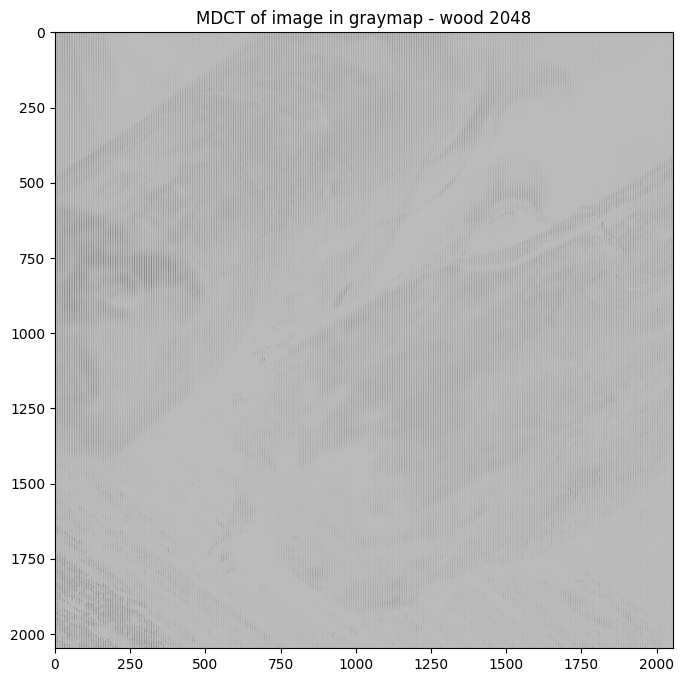

In [28]:
plt.figure()
plt.imshow(im_mdct, cmap='gray')
plt.title(f"MDCT of image in graymap - {image} {size}")

plt.imsave(f'{output}/mdct.png', im_mdct, cmap='gray')

In [29]:
print(im.max(), im.min())
print(im_mdct.max(), im_mdct.min())

254 0
125.13587444077461 -348.77899635287184


In [30]:
for i in range(im_mdct.shape[0]):
    for j in range(0, im_mdct.shape[1], 8):
        im_mdct[i][j:j+8][[7]] = 0

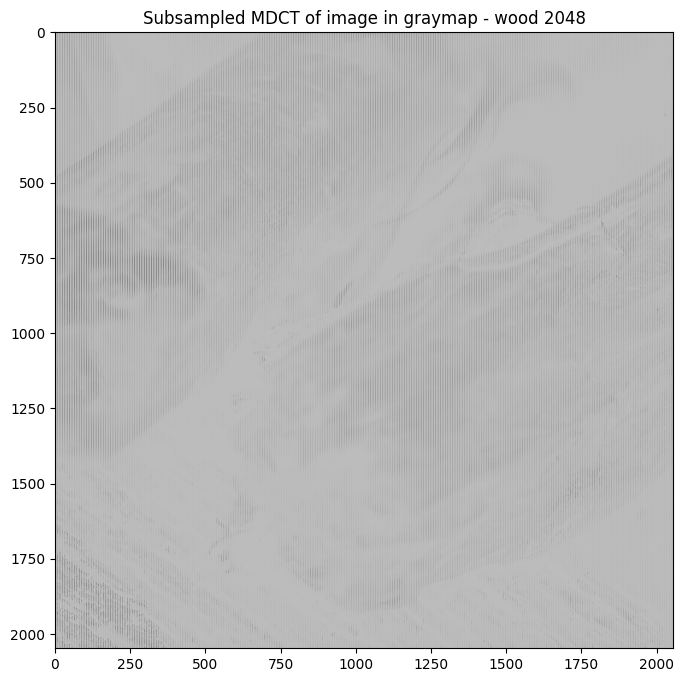

In [31]:
plt.figure()
plt.imshow(im_mdct, cmap='gray')
plt.title(f"Subsampled MDCT of image in graymap - {image} {size}")

plt.imsave(f'{output}/mdct-sub.png', im_mdct, cmap='gray')

In [32]:
im_rec = np.zeros_like(im_hpad, dtype=np.float64)

for i in range(im_mdct.shape[0]):
    for j in range(0, im_mdct.shape[1], 8):
        im_rec[i][j:j+16] += imdct(im_mdct[i][j:j+8]) * wfltr

im_rec = im_rec[:, 8:-8]

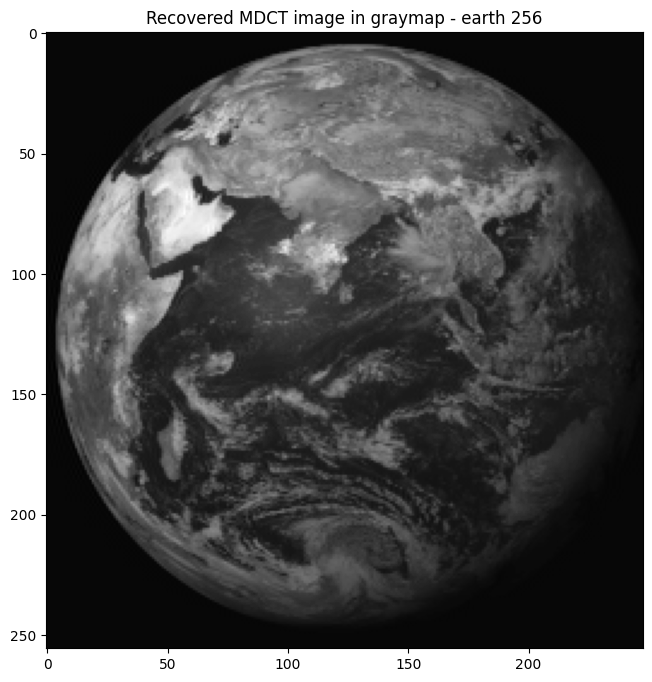

In [ ]:
plt.figure()
plt.imshow(im_rec, cmap='gray')
plt.title(f"Recovered MDCT image in graymap - {image} {size}")

plt.imsave(f'{output}/rec.png', im_rec, cmap='gray')

In [ ]:
abs(im - im_rec) / (im + 1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

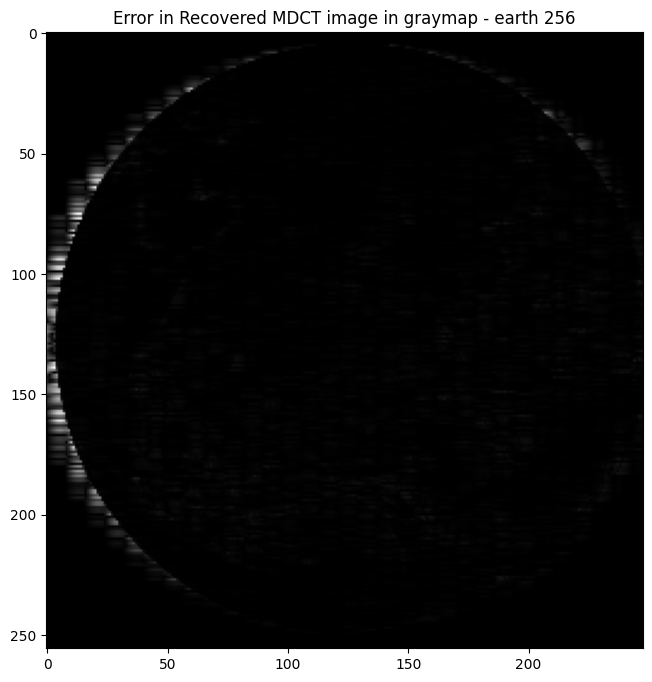

In [ ]:
plt.figure()
plt.imshow(abs(im - im_rec)  / (im + 1), cmap='gray')
plt.title(f"Error in Recovered MDCT image in graymap - {image} {size}")

plt.imsave(f'{output}/rec_err.png', abs(im - im_rec)  / (im + 1), cmap='gray')

In [ ]:
a = np.arange(20, 36)

In [ ]:
a

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [ ]:
mdct(a)

array([-58.75279625, -15.74310374,  10.66346391,   7.49323444,
        -6.38270484,  -5.45866707,   5.10812561,   4.87613354])

In [ ]:
imdct(mdct(a))

array([-7., -5., -3., -1.,  1.,  3.,  5.,  7., 63., 63., 63., 63., 63.,
       63., 63., 63.])

In [ ]:
imdct(np.hstack([mdct(a)[4:], np.zeros(4)]))[8:] + imdct(np.hstack([mdct(a)[4:], np.zeros(4)]))[:8]

array([10.905739  , 21.85851272, 14.51868704,  3.57484258,  3.02780198,
        8.218751  ,  7.69926613,  2.63611397])

In [ ]:
imdct(mdct(a))[8:] + imdct(mdct(a))[:8]

array([56., 58., 60., 62., 64., 66., 68., 70.])